In [87]:
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers
import pandas as pd

In [38]:
#Fijamos la SEED para evitar que varien los numeros generados aleatoriamente.
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [39]:
#1A CARGA Y NORMALIZACION. 

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# convertimos labels a vector 1D
y_train = y_train.flatten()
y_test = y_test.flatten()

# normalizamos al convertir a float32 y dividir por 255
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
print('Train shape:', x_train.shape, 'Test shape:', x_test.shape)

Train shape: (50000, 32, 32, 3) Test shape: (10000, 32, 32, 3)


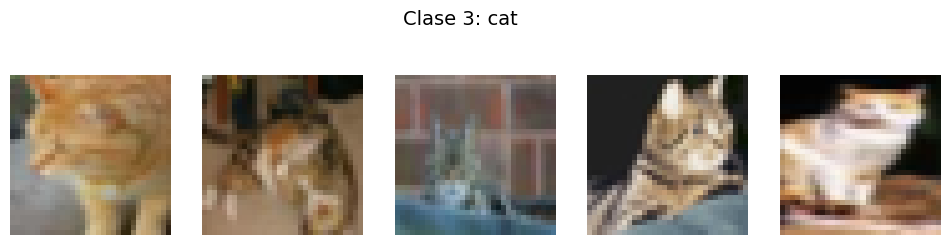

In [61]:
#1B función para muestrear 5 imágenes aleatorias de una clase y mostrarlas en grilla

def mostrar_cinco_por_clase1(clase_idx):
    
    # buscar índices de las imágenes de esa clase
    indices = np.where(y_train == clase_idx)[0]
    # seleccionar 5 al azar
    sampled = np.random.choice(indices, size=5, replace=False)
    # crear figura con 5 subplots
    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    for ax, idx in zip(axes, sampled):
        ax.imshow(x_train[idx])
        ax.axis('off')
    fig.suptitle(f'Clase {clase_idx}: {class_names[clase_idx]}', fontsize=14)
    plt.show()

mostrar_cinco_por_clase1(3)

In [ ]:
def make_model(input_shape=(32,32,3), num_classes=10):
    
    inputs = keras.Input(shape=input_shape)

    # Data augmentation: aplicamos transformaciones aleatorias a los datos de entrenamiento para aumentar la diversidad del set y reducir la posibilidad de que haya overfitting.

    x = layers.RandomFlip("horizontal")(inputs)
    x = layers.RandomRotation(0.08)(x)
    x = layers.RandomZoom(0.08)(x)

    # Bloque 1: detecta patrones básicos (bordes, colores, texturas).
    x = layers.Conv2D(32, (3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, (3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)

    # Bloque 2: extrae patrones más complejos (combinaciones de bordes, formas).
    x = layers.Conv2D(64,(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64,(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)

    # Bloque 3: captura estructuras de alto nivel (partes de objetos, texturas complejas).
    x = layers.Conv2D(128,(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128,(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)

    #clasificacion final
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs)



In [66]:
#Compilacion del modelo
model = make_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 32, 32, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 307,114 (1.17 MB)

 Trainable params: 305,962 (1.17 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [68]:
# Callbacks
# Este callback ajusta de forma automatica el learning rate para hacer mas ajustes finos cuando el modelo parece estancarse.
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)
# Este callback detiene el entrenamiento si no hay mejoras, evitando el sobreajuste y garantizando que los pesos más generales (no sobreajustados) sean los que se mantengan.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

In [69]:
# Entrenamiento

EPOCHS = 40          
BATCH = 128
history = model.fit(x_train, y_train,
                    validation_split=0.1,
                    epochs=EPOCHS,
                    batch_size=BATCH,
                    callbacks=[reduce_lr, early_stop])

Epoch 1/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 52s 140ms/step - accuracy: 0.3587 - loss: 1.7834 - val_accuracy: 0.3070 - val_loss: 2.2439 - learning_rate: 0.0010
Epoch 2/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 48s 137ms/step - accuracy: 0.5029 - loss: 1.3731 - val_accuracy: 0.5016 - val_loss: 1.3843 - learning_rate: 0.0010
Epoch 3/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 49s 140ms/step - accuracy: 0.5593 - loss: 1.2367 - val_accuracy: 0.5470 - val_loss: 1.2655 - learning_rate: 0.0010
Epoch 4/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 50s 143ms/step - accuracy: 0.5953 - loss: 1.1390 - val_accuracy: 0.5420 - val_loss: 1.4233 - learning_rate: 0.0010
Epoch 5/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 51s 144ms/step - accuracy: 0.6196 - loss: 1.0803 - val_accuracy: 0.6492 - val_loss: 0.9859 - learning_rate: 0.0010
Epoch 6/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 52s 147ms/step - accuracy: 0.6428 - loss: 1.0235 - val_accuracy: 0.6572 - val_loss: 0.9688 - learning_rate: 0.0010
Epoch 7/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - accuracy: 0.6

# 2A. Elección de arquitectura e hiperparámetros

La elección de una red convolucional es natural para el problema de clasificación de imágenes, ya que este tipo de red es excelente para aprender patrones visuales jerárquicos.

Capas convolucionales con más filtros en las capas profundas: Esto permite que el modelo capture detalles de bajo nivel en las primeras capas y características más complejas en las capas más profundas.

Uso de BatchNormalization y ReLU: Ayuda a estabilizar y acelerar el entrenamiento.

MaxPooling y Dropout: Ayuda a mejorar la eficiencia del modelo y prevenir el sobreajuste.

Uso de un número razonable de épocas (40): No es ni demasiado poco ni demasiado, y EarlyStopping garantiza que no se entrene innecesariamente.

Hiperparámetros como batch size y learning rate: Elegidos para lograr un entrenamiento estable y eficiente sin que el modelo aprenda demasiado rápido o demasiado lento.


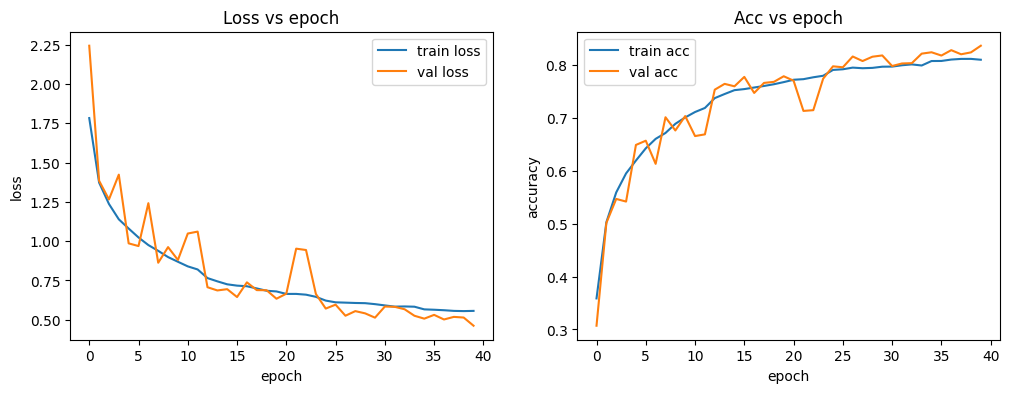

In [70]:
#2B Graficos

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.title('Loss vs epoch')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.legend(); plt.title('Acc vs epoch')
plt.show()

313/313 - 3s - 9ms/step - accuracy: 0.8345 - loss: 0.4900
Test loss: 0.4900 - Test accuracy: 0.8345
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Classification report:
              precision    recall  f1-score   support

    airplane     0.8606    0.8270    0.8434      1000
  automobile     0.9176    0.9350    0.9262      1000
        bird     0.8036    0.7650    0.7838      1000
         cat     0.8003    0.6130    0.6942      1000
        deer     0.7849    0.8500    0.8161      1000
         dog     0.8160    0.7230    0.7667      1000
        frog     0.7558    0.9410    0.8383      1000
       horse     0.8618    0.8790    0.8703      1000
        ship     0.8898    0.9040    0.8968      1000
       truck     0.8631    0.9080    0.8850      1000

    accuracy                         0.8345     10000
   macro avg     0.8353    0.8345    0.8321     10000
weighted avg     0.8353    0.8345    0.8321     10000



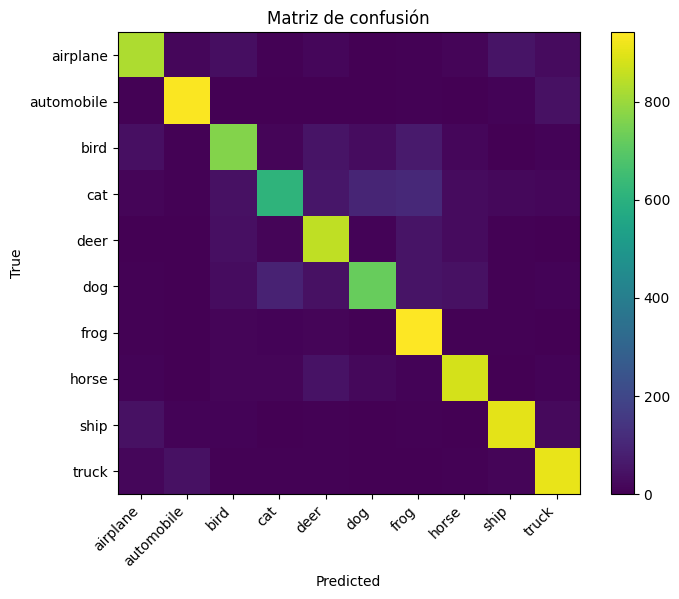

In [ ]:
#2C Evaluacion

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test loss: {test_loss:.4f} - Test accuracy: {test_acc:.4f}")

y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)

print("Classification report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Matriz de confusión")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(np.arange(len(class_names)), class_names, rotation=45, ha='right')
plt.yticks(np.arange(len(class_names)), class_names)
plt.colorbar()
plt.show()


El modelo tiene un buen test accuracy (83.45%) y parece funcionar bastante bien en la mayoría de las clases.

Tiene un excelente rendimiento con clases como Automobile (precisión: 91.76%, recall: 93.50%) y Ship (precisión: 88.98%, recall: 90.40%). Esto indica que el modelo es muy confiable para estas clases.

El modelo tiene algo más de dificultad con las clases Cat (precisión: 80.03%, recall: 61.30%) y Dog (precisión: 81.60%, recall: 72.30%). El recall bajo en Cat indica que está teniendo problemas para identificar correctamente todas las imágenes de gatos.

First conv weights shape: (3, 3, 3, 32)


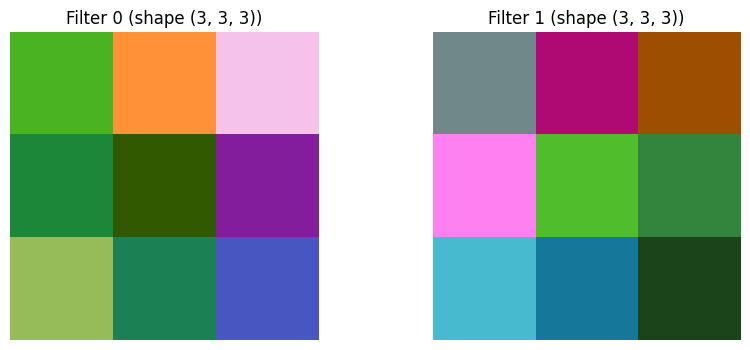

In [82]:
#3A. Mostrar 2 filtros aprendidos

first_conv = None
for layer in model.layers:
    if isinstance(layer, layers.Conv2D):
        first_conv = layer
        break
weights, biases = first_conv.get_weights()  # shape (k,k,in_ch,filters)
print("First conv weights shape:", weights.shape)

num_filters = weights.shape[-1]
f1, f2 = 0, 1
filter_indices = [f1, f2]

def show_filter_heatmaps(filter_indices):
    fig, axes = plt.subplots(1, len(filter_indices), figsize=(5*len(filter_indices),4))
    if len(filter_indices) == 1: axes = [axes]
    for ax, fi in zip(axes, filter_indices):
        filt = weights[:,:,:,fi]  # (k,k,3)
        mn, mx = filt.min(), filt.max()
        vis = (filt - mn) / (mx - mn + 1e-9)
        ax.imshow(vis, interpolation='nearest')
        ax.set_title(f"Filter {fi} (shape {filt.shape})")
        ax.axis('off')
    plt.show()

show_filter_heatmaps(filter_indices)


Al observar los filtros aprendidos por la primera capa, observamos que ambos tienen una estructura similar. Estas capas iniciales se encargan de detectar patrones simples y mas generales como pueden ser bordes, contrastes de color, transiciones de colores, texturas, etc.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


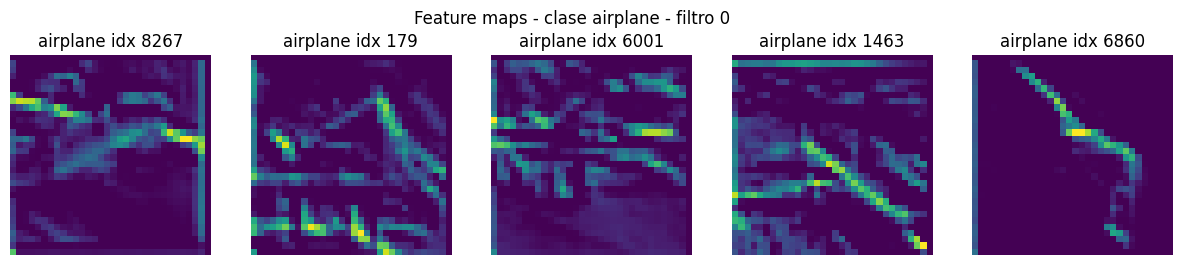

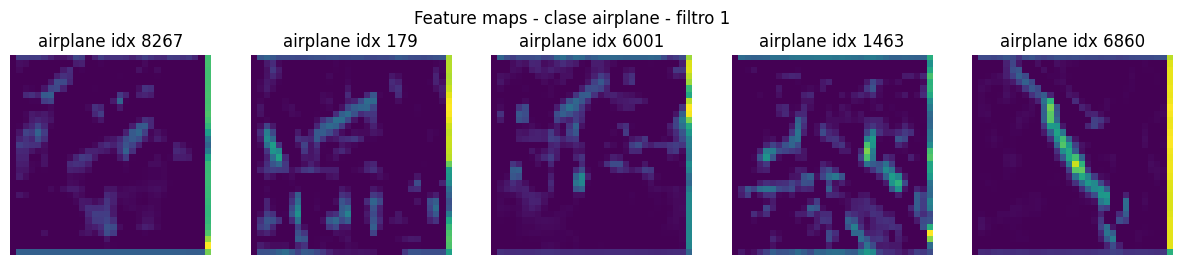

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


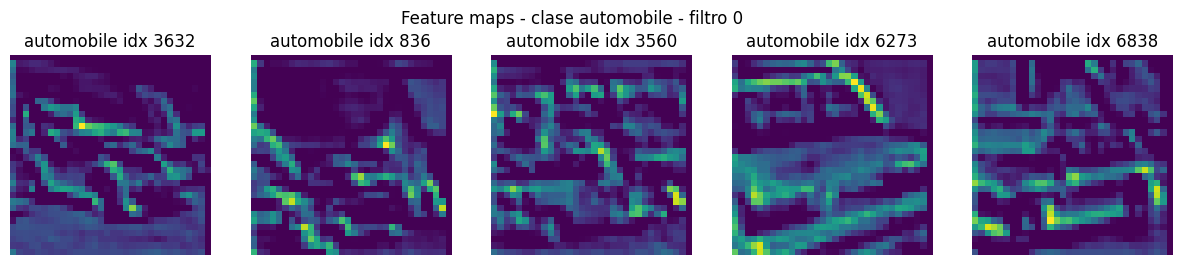

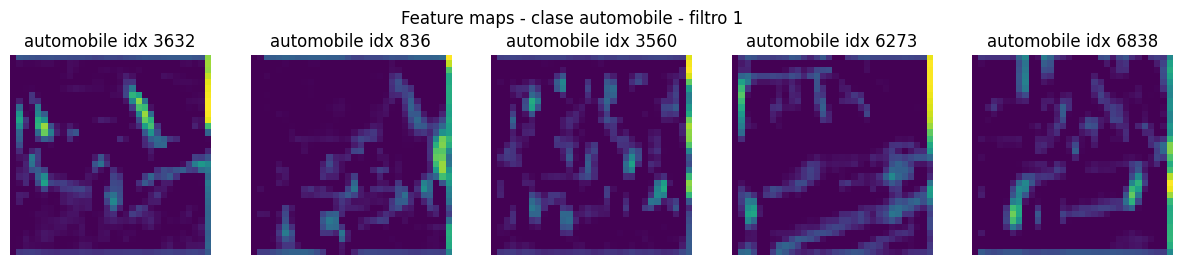

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


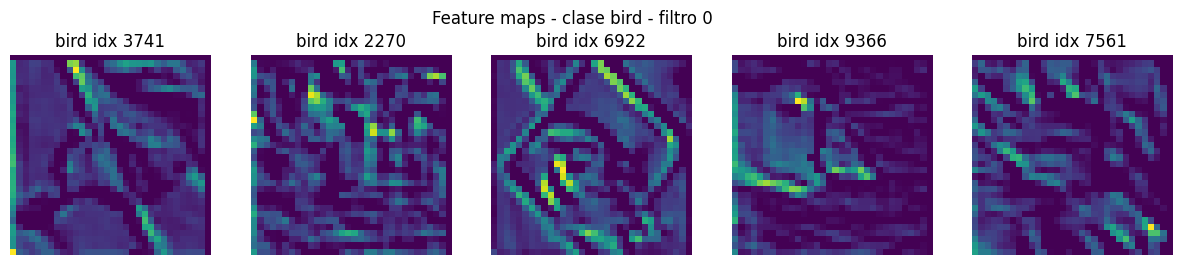

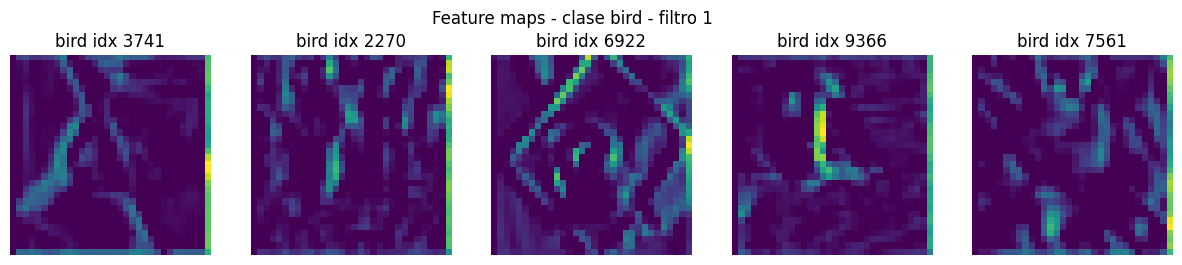

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


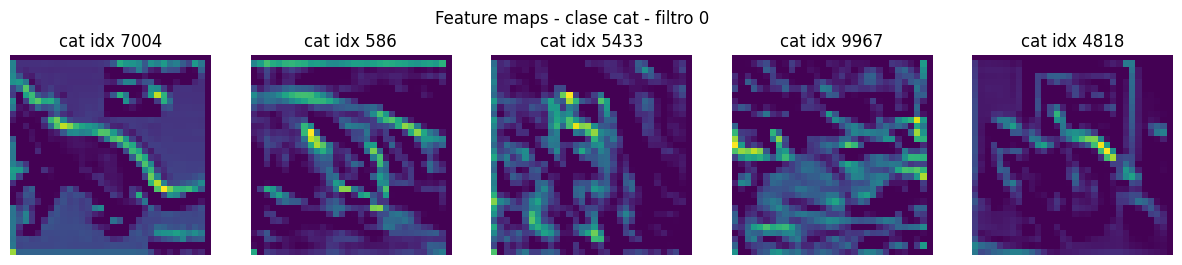

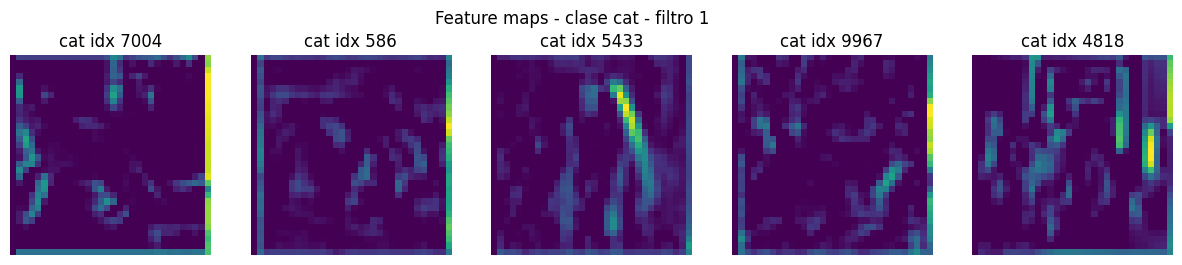

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


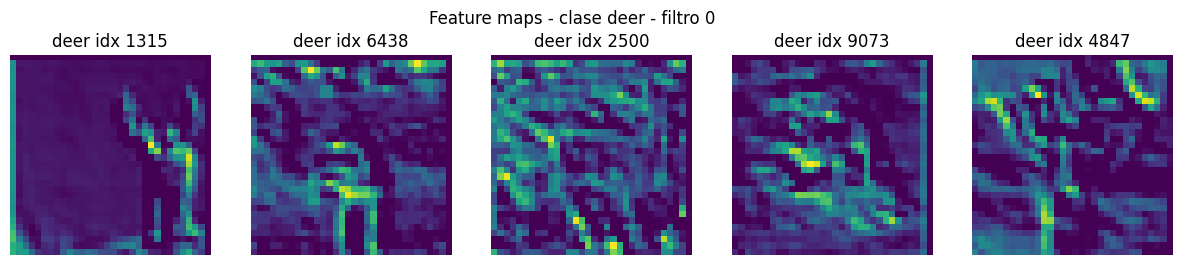

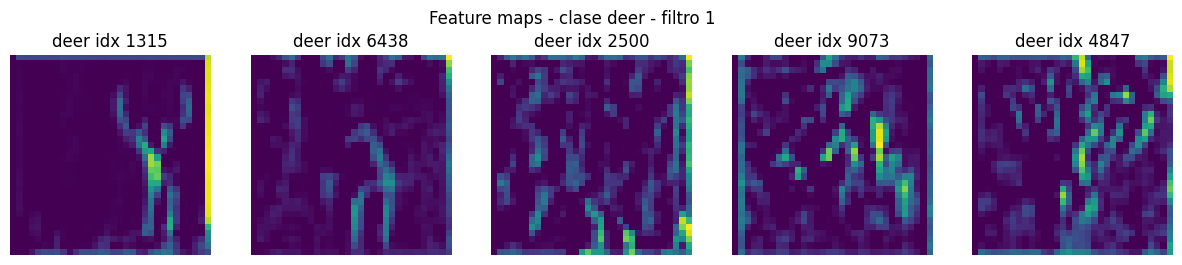

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


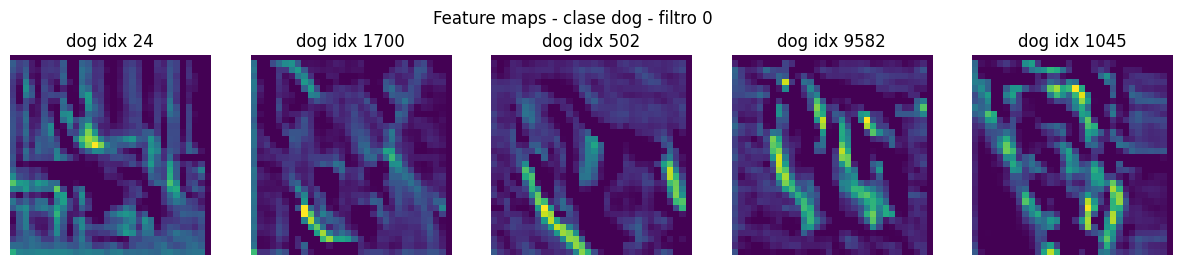

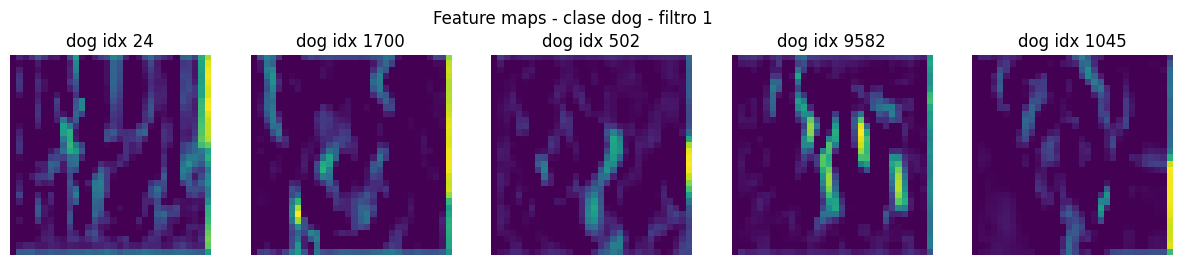

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


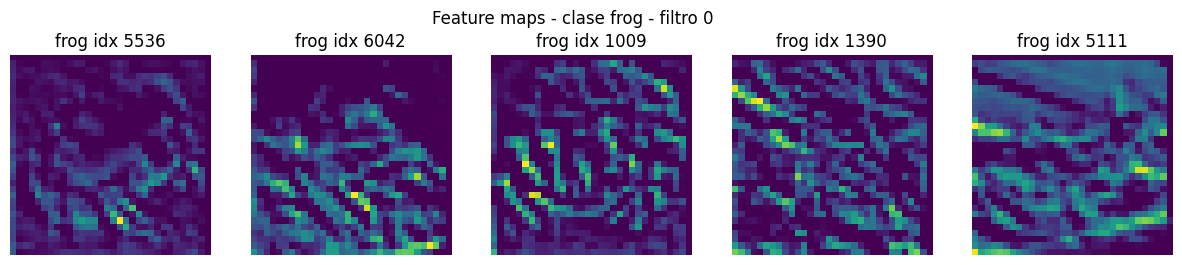

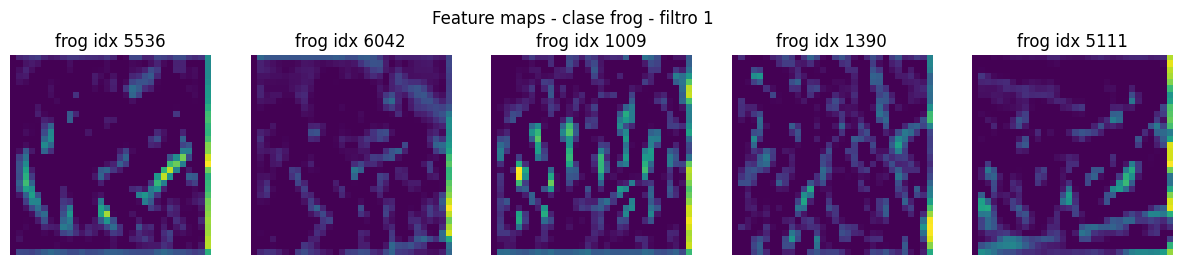

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


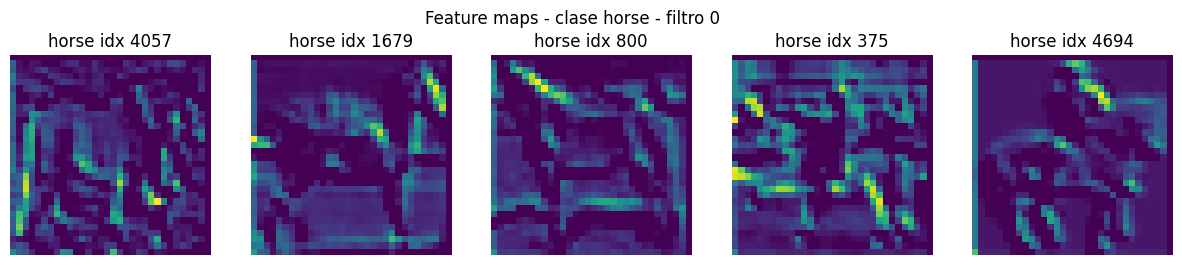

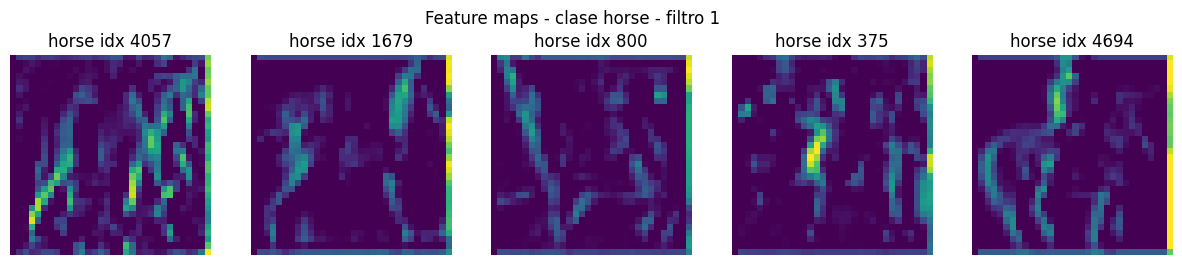

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


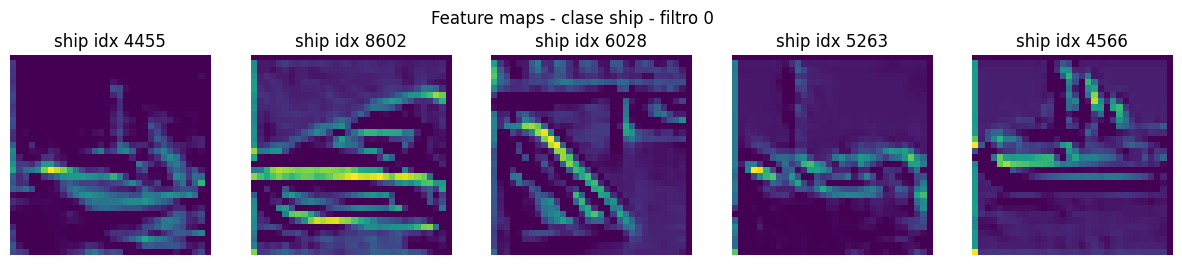

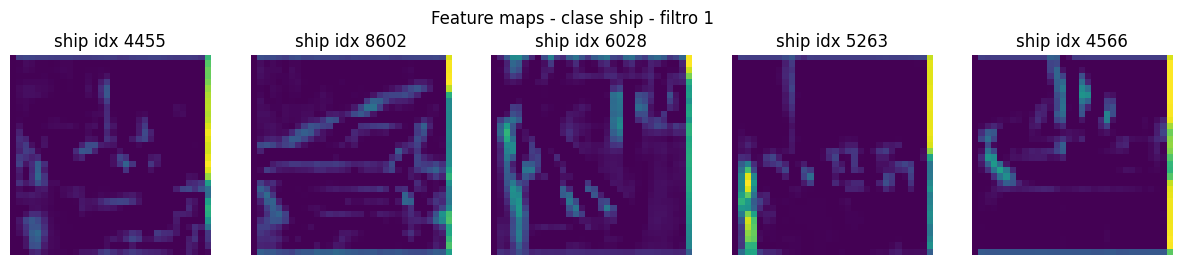

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


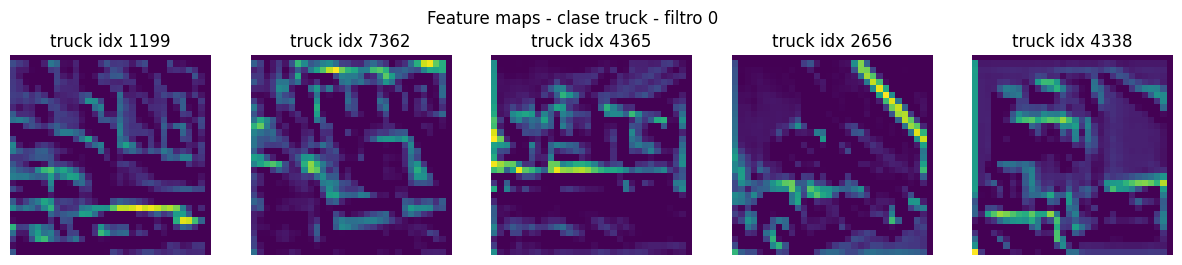

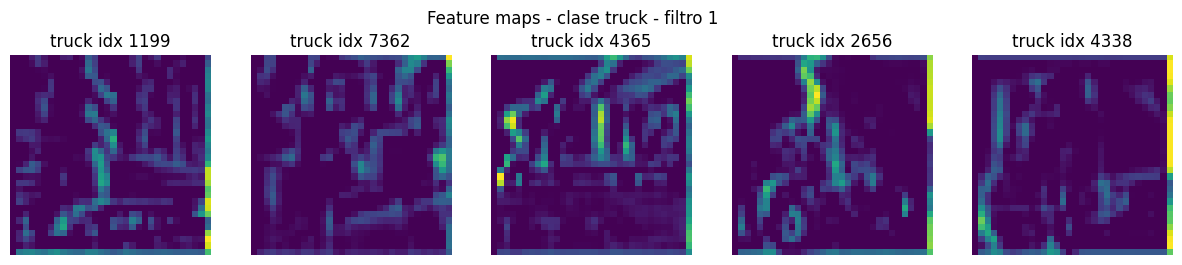

In [85]:
#3C. Funcion que muestra feature maps para las dos filtros seleccionados, para 5 imágenes de cada clase

def get_activation_model(model, conv_layer):
    idx = model.layers.index(conv_layer)
    out_layer_idx = idx
    for j in range(idx, min(idx+6, len(model.layers))):
        if isinstance(model.layers[j], layers.ReLU):
            out_layer_idx = j
            break
    return keras.Model(inputs=model.inputs, outputs=model.layers[out_layer_idx].output)

act_model = get_activation_model(model, first_conv)

def show_feature_maps_for_filters(filter_indices, samples_per_class=5):
    for cls in range(10):
        indices = np.where(y_test == cls)[0]
        chosen = np.random.choice(indices, size=samples_per_class, replace=False)
        batch = x_test[chosen]
        acts = act_model.predict(batch)  # (samples, H, W, channels)
        for fi in filter_indices:
            fig, axes = plt.subplots(1, samples_per_class, figsize=(3*samples_per_class,3))
            for i in range(samples_per_class):
                fmap = acts[i,:,:,fi]
                axes[i].imshow(fmap, interpolation='nearest')
                axes[i].axis('off')
                axes[i].set_title(f"{class_names[cls]} idx {chosen[i]}")
            plt.suptitle(f"Feature maps - clase {class_names[cls]} - filtro {fi}")
            plt.show()

show_feature_maps_for_filters(filter_indices, samples_per_class=5)

Los feature maps muestran qué zonas de la imagen activan más a cada filtro de la red convolucional.
En las imágenes se observan regiones resaltadas (en amarillo o verde brillante) que indican dónde el filtro detectó patrones que considera relevantes.

Por ejemplo, para la clase “airplane”, ambos filtros se activan principalmente sobre bordes diagonales y líneas alargadas, que son características típicas de la forma de un avión (alas, fuselaje).

Aunque los dos filtros parecen responder a patrones similares, cada uno capta variaciones distintas de la misma característica.

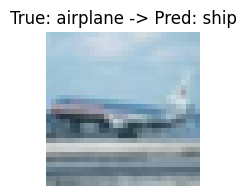

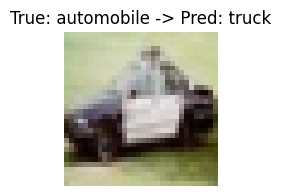

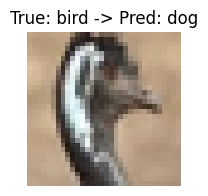

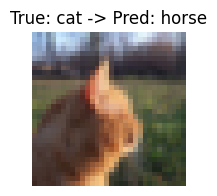

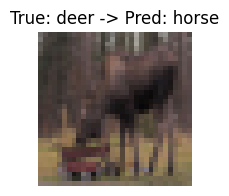

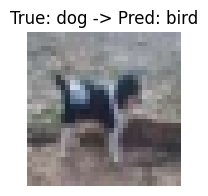

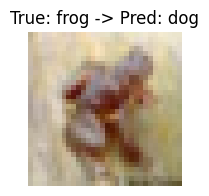

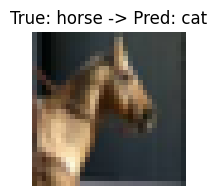

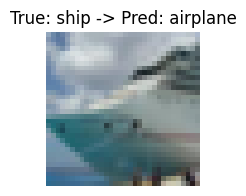

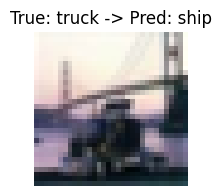

        class  accuracy
0    airplane     0.827
1  automobile     0.935
2        bird     0.765
3         cat     0.613
4        deer     0.850
5         dog     0.723
6        frog     0.941
7       horse     0.879
8        ship     0.904
9       truck     0.908


In [89]:
#4. Tomar un ejemplo mal clasificado de cada clase

misclassified_examples = []
for cls in range(10):
    inds = np.where((y_test == cls) & (y_pred != cls))[0]
    if len(inds) == 0:
        print(f"No hay ejemplos mal clasificados para la clase {class_names[cls]}")
        continue
    idx = np.random.choice(inds)
    misclassified_examples.append((cls, idx, y_pred[idx]))

for true_cls, idx, pred_cls in misclassified_examples:
    plt.figure(figsize=(4,2))
    plt.imshow(x_test[idx])
    plt.axis('off')
    plt.title(f"True: {class_names[true_cls]} -> Pred: {class_names[pred_cls]}")
    plt.show()

# Accuracy por clase
per_class_acc = cm.diagonal() / cm.sum(axis=1)
df_acc = pd.DataFrame({'class': class_names, 'accuracy': per_class_acc})
print(df_acc)

En algunos casos el modelo parece confundir clases debido a su forma y/o fondo.